In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Bahia - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_BA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Bahia - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.299858,10915.348400,151.297,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.301903,11028.218400,138.707,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.303709,11133.335807,135.009,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.305311,11215.137236,126.554,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.306860,11294.955512,137.331,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


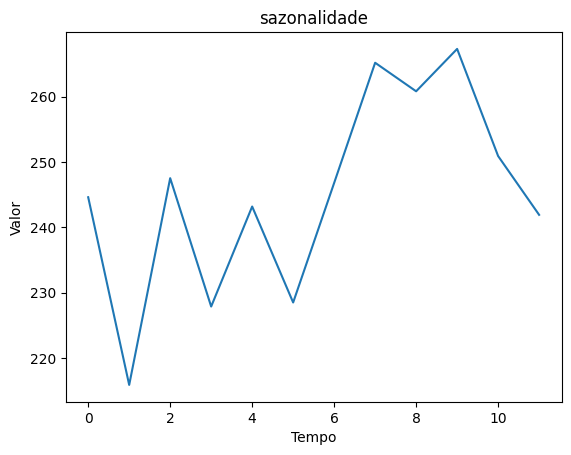

,sazonalidade
sazonalidade,
0,244.600078
1,215.892350
2,247.514433
3,227.882129
4,243.178316
5,228.500346
6,246.785650
7,265.169678
8,260.802979


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Bahia - Consumo de Cimento (t)
0,2003-1,0.299858,10915.348400,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,244.600078,151.297
1,2003-2,0.301903,11028.218400,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,215.892350,138.707
2,2003-3,0.303709,11133.335807,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,247.514433,135.009
3,2003-4,0.305311,11215.137236,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,227.882129,126.554
4,2003-5,0.306860,11294.955512,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.178316,137.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.178316,NaN
269,2002-9,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.500346,NaN
270,2002-10,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.785650,NaN
271,2002-11,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.169678,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Bahia - Consumo de Cimento (t), Length: 273, dtype: float64

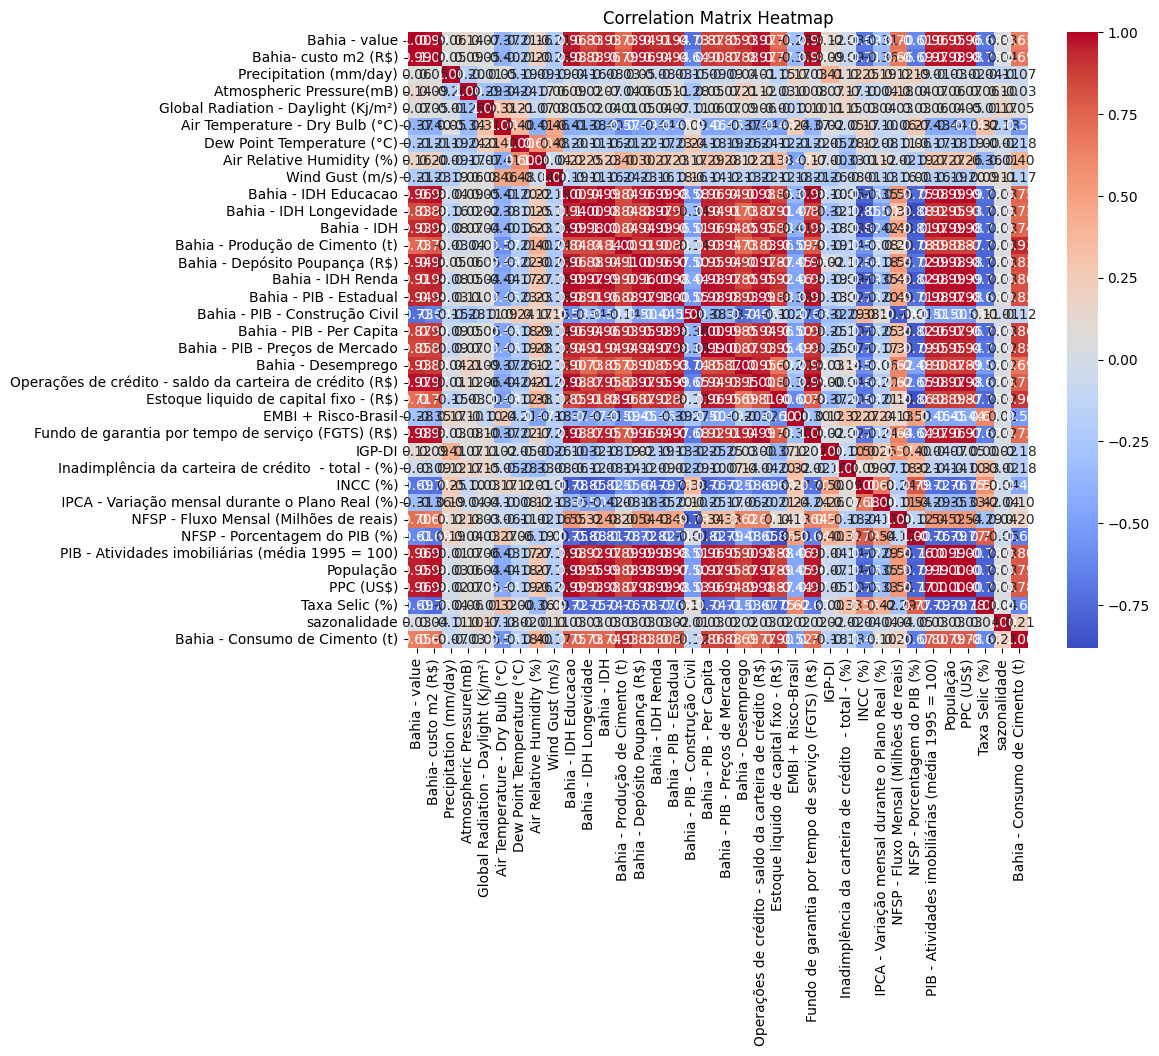

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Bahia - value,1.561223e+04
1,Bahia- custo m2 (R$),4.927602e+04
2,Precipitation (mm/day),5.178244e+00
3,Atmospheric Pressure(mB),9.355761e+00
4,Global Radiation - Daylight (Kj/m²),1.069879e+01
5,Air Temperature - Dry Bulb (°C),4.029328e+01
6,Dew Point Temperature (°C),7.404451e+01
7,Air Relative Humidity (%),9.222344e+01
8,Wind Gust (m/s),1.452925e+01
9,Bahia - IDH Educacao,7.937955e+05


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 3


,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.299858,10915.348400,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,1.216359e+08,8.348779,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,244.600078
1,0.301903,11028.218400,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,1.216914e+08,8.342979,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,215.892350
2,0.303709,11133.335807,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,1.217469e+08,8.337179,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,247.514433
3,0.305311,11215.137236,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,1.218023e+08,8.331379,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,227.882129
4,0.306860,11294.955512,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,1.218578e+08,8.325579,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.178316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.506442,27557.707384,2.153143,1010.373883,1404.752677,25.324521,20.946946,77.372115,1.407771,0.654470,98.262920,2.313473e+07,0.661505,1.541085e+08,8.257830e+06,1.252684e+08,15.540546,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,265.169678
200,0.507843,27825.658749,2.157162,1009.431610,1506.904370,25.689277,21.146790,76.670826,1.413450,0.654344,98.658475,2.344872e+07,0.661487,1.539597e+08,8.259820e+06,1.252407e+08,15.535538,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,260.802979
201,0.509609,28102.378476,2.261380,1008.579612,1563.779383,26.104354,21.420589,76.117504,1.400989,0.654218,99.062891,2.376271e+07,0.661469,1.538110e+08,8.261811e+06,1.252131e+08,15.530530,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,267.283984
202,0.511269,28386.571532,2.368170,1007.976093,1592.474270,26.547290,21.792400,75.845430,1.364039,0.654092,98.741893,2.407670e+07,0.661451,1.536622e+08,8.263801e+06,1.251855e+08,15.525523,3.425371e+

In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.637017,-0.104765,-0.710842,1.257265,0.655790,0.037353,-0.195643,1.466065,-1.890989,-1.793459,-1.607675,-2.210000,-1.766933,-0.695996,-2.238131,-0.944845,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141
1,-1.612708,1.140931,-0.619066,0.718602,0.442085,0.069587,0.133953,0.547047,-1.868832,-1.806616,-1.598469,-2.177528,-1.747868,-0.654222,-2.196868,-0.946500,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904
2,-1.590068,1.317245,-0.364460,0.097559,0.072623,0.041500,0.457445,-0.323857,-1.846676,-1.809908,-1.589263,-2.145055,-1.728803,-0.612447,-2.155605,-0.948156,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828
3,-1.572450,1.358281,0.184493,-0.398630,-0.378545,-0.105716,0.522863,-1.135338,-1.824519,-1.809210,-1.580058,-2.112583,-1.709739,-0.570673,-2.114342,-0.949811,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354
4,-1.555260,1.143559,0.719418,-0.758566,-0.900673,-0.250858,0.680897,-1.747105,-1.802362,-1.806620,-1.570852,-2.080111,-1.690674,-0.528898,-2.073079,-0.951467,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.947296,0.997566,0.948064,-0.155863,-0.783229,-0.372662,0.219862,-0.505057,1.208211,0.619029,1.569374,0.966650,0.865987,-1.416165,0.463875,1.107985,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268
200,2.005006,1.005637,0.363109,0.388904,-0.464955,-0.304412,0.071234,-0.486292,1.201241,0.635352,1.634353,0.964148,0.848481,-1.404857,0.443334,1.106555,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925
201,2.064604,1.214926,-0.165804,0.692215,-0.102772,-0.210906,-0.046034,-0.527469,1.194270,0.652040,1.699331,0.961646,0.830975,-1.393550,0.422793,1.105126,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663
202,2.125811,1.429382,-0.540464,0.845242,0.283720,-0.083927,-0.103696,-0.649577,1.187300,0.638794,1.764310,0.959144,0.813469,-1.382243,0.402252,1.103697,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.637017,-0.104765,-0.710842,1.257265,0.655790,0.037353,-0.195643,1.466065,-1.890989,-1.793459,-1.607675,-2.210000,-1.766933,-0.695996,-2.238131,-0.944845,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141
1,-1.612708,1.140931,-0.619066,0.718602,0.442085,0.069587,0.133953,0.547047,-1.868832,-1.806616,-1.598469,-2.177528,-1.747868,-0.654222,-2.196868,-0.946500,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904
2,-1.590068,1.317245,-0.364460,0.097559,0.072623,0.041500,0.457445,-0.323857,-1.846676,-1.809908,-1.589263,-2.145055,-1.728803,-0.612447,-2.155605,-0.948156,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828
3,-1.572450,1.358281,0.184493,-0.398630,-0.378545,-0.105716,0.522863,-1.135338,-1.824519,-1.809210,-1.580058,-2.112583,-1.709739,-0.570673,-2.114342,-0.949811,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354
4,-1.555260,1.143559,0.719418,-0.758566,-0.900673,-0.250858,0.680897,-1.747105,-1.802362,-1.806620,-1.570852,-2.080111,-1.690674,-0.528898,-2.073079,-0.951467,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.453575,-0.540575,0.699130,-0.061733,-0.811615,-0.506036,-0.125022,-0.405938,1.265921,0.484754,1.080645,1.048866,1.046328,-1.515603,0.710508,1.119801,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820
188,1.476814,-0.052281,0.260101,0.242882,-0.534699,-0.424540,-0.189625,-0.352673,1.264137,0.486517,1.087420,1.035925,1.034768,-1.511546,0.689938,1.119439,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503
189,1.503389,-0.042660,0.042791,0.701710,-0.152673,-0.323073,-0.299351,-0.383816,1.262353,0.500299,1.094195,1.022984,1.023208,-1.507488,0.669369,1.119077,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444
190,1.532998,-0.259945,-0.234496,1.100753,0.290570,-0.203668,-0.426560,-0.444471,1.260570,0.498868,1.100971,1.010043,1.011648,-1.503430,0.648800,1.118715,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
187    354.650
188    365.171
189    376.053
190    320.599
191    307.244
Name: Bahia - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 30)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
156,0.862619,-0.621549,-0.376690,0.865504,0.810044,-0.062727,-0.571267,-0.324874,1.276480,0.624135,0.676462,1.227406,1.153703,-1.167972,1.050232,1.196956,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265
157,0.880615,-0.524729,-0.133895,0.724450,0.755957,-0.084866,-0.576834,-0.469549,1.276357,0.592376,0.688039,1.219356,1.155060,-1.192600,1.044280,1.191711,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084
158,0.898552,-0.428777,0.214206,0.133412,0.487115,-0.134660,-0.441065,-0.336526,1.276233,0.564855,0.699616,1.211305,1.156418,-1.217228,1.038328,1.186467,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087
159,0.916954,-0.478022,0.633017,-0.356135,0.003260,-0.258319,-0.289411,-0.356668,1.276110,0.535647,0.711192,1.203254,1.157775,-1.241857,1.032375,1.181223,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300
160,0.932866,-0.248845,1.107254,-0.672549,-0.488362,-0.397689,-0.162316,-0.292035,1.275986,0.496945,0.722769,1.195204,1.159133,-1.266485,1.026423,1.175978,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403
161,0.949403,-0.663014,1.368538,-0.607979,-0.736393,-0.510534,-0.227611,-0.256506,1.275863,0.485613,0.734346,1.187153,1.160490,-1.291113,1.020470,1.170734,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434
162,0.967117,-0.933705,1.321333,-0.174654,-0.752379,-0.541971,-0.305115,-0.342500,1.275739,0.473211,0.745923,1.179102,1.161848,-1.315741,1.014518,1.165490,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553
163,0.984950,-0.916783,0.979208,0.079943,-0.642259,-0.505301,-0.317124,-0.195402,1.275616,0.469766,0.757500,1.171052,1.163205,-1.340370,1.008566,1.160245,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038
164,1.003217,-1.060161,0.526111,0.476621,-0.335055,-0.422226,-0.410413,-0.123854,1.275493,0.457435,0.769077,1.163001,1.164562,-1.364998,1.002613,1.155001,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412
165,1.022066,-0.894401,0.091422,1.023336,0.022387,-0.370698,-0.621374,-0.030553,1.275369,0.454716,0.780654,1.154950,1.165920,-1.389626,0.996661,1.149757,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2922296636, 496370889, 2880590663, 2951046664, 3473945450, 1570889252, 256981279, 247818113, 3363841321, 1739598615]


Step: 0 ___________________________________________
val_loss: 2759.4013671875
winner_seed: 2922296636


Step: 1 ___________________________________________
val_loss: 1494.7459716796875
winner_seed: 496370889


Step: 2 ___________________________________________
val_loss: 1410.6727294921875
winner_seed: 2880590663


Step: 3 ___________________________________________
val_loss: 3584.208740234375


Step: 4 ___________________________________________
val_loss: 3328.952392578125


Step: 5 ___________________________________________
val_loss: 2196.357666015625


Step: 6 ___________________________________________
val_loss: 2972.467529296875


Step: 7 ___________________________________________
val_loss: 2708.707275390625


Step: 8 ___________________________________________
val_loss: 2415.929931640625


Step: 9 ___________________________________________
val_loss: 2186.4453

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2536234443

Epoch 1/10000
5/5 [==============================] - 2s 97ms/step - loss: 45953.2617 - val_loss: 3922.4287
Epoch 2/10000
5/5 [==============================] - 0s 11ms/step - loss: 2168.3035 - val_loss: 2498.4744
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 2173.4697 - val_loss: 2714.6794
Epoch 4/10000
5/5 [==============================] - 0s 9ms/step - loss: 2139.4436 - val_loss: 2409.2629
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 2128.5317 - val_loss: 3530.0422
Epoch 6/10000
5/5 [==============================] - 0s 8ms/step - loss: 2076.5249 - val_loss: 5473.2676
Epoch 7/10000
5/5 [==============================] - 0s 8ms/step - loss: 2145.7786 - val_loss: 2322.2087
Epoch 8/10000
5/5 [==============================] - 0s 9ms/step - loss: 1937.4257 - val_loss: 3494.3096
Epoch 9/10000
5/5 [==============================] - 0s 10ms/step - loss: 1744.5078 - val_loss: 2562.5725
Epoch 10/10000
5/5 [==============================

5/5 [==============================] - 0s 10ms/step - loss: 500.1294 - val_loss: 4071.9255
Epoch 79/10000
5/5 [==============================] - 0s 10ms/step - loss: 535.6556 - val_loss: 5746.6074
Epoch 80/10000
5/5 [==============================] - 0s 11ms/step - loss: 532.0517 - val_loss: 5135.9224
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 505.1023 - val_loss: 3867.4607
Epoch 82/10000
5/5 [==============================] - 0s 8ms/step - loss: 606.6141 - val_loss: 6513.4863
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 491.5852 - val_loss: 4973.0581
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 468.1413 - val_loss: 5991.9434
Epoch 85/10000
5/5 [==============================] - 0s 10ms/step - loss: 503.1610 - val_loss: 3850.5774
Epoch 86/10000
5/5 [==============================] - 0s 10ms/step - loss: 687.6519 - val_loss: 6659.9487
Epoch 87/10000
5/5 [==============================] - 0s 9ms/ste

5/5 [==============================] - 0s 9ms/step - loss: 403.1515 - val_loss: 2412.7598
Epoch 156/10000
5/5 [==============================] - 0s 9ms/step - loss: 415.0095 - val_loss: 4332.4619
Epoch 157/10000
5/5 [==============================] - 0s 10ms/step - loss: 385.0619 - val_loss: 2454.0933
Epoch 158/10000
5/5 [==============================] - 0s 9ms/step - loss: 347.9626 - val_loss: 2274.6018
Epoch 159/10000
5/5 [==============================] - 0s 10ms/step - loss: 362.3275 - val_loss: 3669.0688
Epoch 160/10000
5/5 [==============================] - 0s 10ms/step - loss: 549.8261 - val_loss: 5502.3374
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 533.6000 - val_loss: 6669.2427
Epoch 162/10000
5/5 [==============================] - 0s 10ms/step - loss: 438.7889 - val_loss: 4090.7861
Epoch 163/10000
5/5 [==============================] - 0s 10ms/step - loss: 362.5802 - val_loss: 4939.3696
Epoch 164/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 9ms/step - loss: 296.3172 - val_loss: 2653.2788
Epoch 233/10000
5/5 [==============================] - 0s 9ms/step - loss: 300.1119 - val_loss: 2857.1792
Epoch 234/10000
5/5 [==============================] - 0s 8ms/step - loss: 277.2186 - val_loss: 4004.2007
Epoch 235/10000
5/5 [==============================] - 0s 9ms/step - loss: 310.0645 - val_loss: 3636.3123
Epoch 236/10000
5/5 [==============================] - 0s 9ms/step - loss: 289.8667 - val_loss: 2685.7717
Epoch 237/10000
5/5 [==============================] - 0s 10ms/step - loss: 290.5001 - val_loss: 2753.4106
Epoch 238/10000
5/5 [==============================] - 0s 9ms/step - loss: 289.3843 - val_loss: 2951.3992
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 281.9128 - val_loss: 2618.5940
Epoch 240/10000
5/5 [==============================] - 0s 8ms/step - loss: 306.7206 - val_loss: 2874.6428
Epoch 241/10000
5/5 [==============================] - 0s 9ms

Epoch 309/10000
5/5 [==============================] - 0s 10ms/step - loss: 227.9561 - val_loss: 2643.2749
Epoch 310/10000
5/5 [==============================] - 0s 10ms/step - loss: 217.5425 - val_loss: 2323.7937
Epoch 311/10000
5/5 [==============================] - 0s 9ms/step - loss: 273.9520 - val_loss: 2185.9783
Epoch 312/10000
5/5 [==============================] - 0s 10ms/step - loss: 236.2587 - val_loss: 2145.4280
Epoch 313/10000
5/5 [==============================] - 0s 10ms/step - loss: 247.2417 - val_loss: 2020.7817
Epoch 314/10000
5/5 [==============================] - 0s 10ms/step - loss: 269.4507 - val_loss: 2583.0649
Epoch 315/10000
5/5 [==============================] - 0s 11ms/step - loss: 235.3007 - val_loss: 2318.3621
Epoch 316/10000
5/5 [==============================] - 0s 9ms/step - loss: 209.8649 - val_loss: 2342.0596
Epoch 317/10000
5/5 [==============================] - 0s 9ms/step - loss: 214.8488 - val_loss: 2179.1531
Epoch 318/10000
5/5 [===================

Epoch 386/10000
5/5 [==============================] - 0s 9ms/step - loss: 212.6394 - val_loss: 2248.9131
Epoch 387/10000
5/5 [==============================] - 0s 10ms/step - loss: 202.7392 - val_loss: 3297.6584
Epoch 388/10000
5/5 [==============================] - 0s 9ms/step - loss: 214.4143 - val_loss: 2606.7300
Epoch 389/10000
5/5 [==============================] - 0s 9ms/step - loss: 191.7932 - val_loss: 2371.0488
Epoch 390/10000
5/5 [==============================] - 0s 9ms/step - loss: 179.1862 - val_loss: 2589.1855
Epoch 391/10000
5/5 [==============================] - 0s 9ms/step - loss: 186.1102 - val_loss: 2515.5366
Epoch 392/10000
5/5 [==============================] - 0s 9ms/step - loss: 174.6633 - val_loss: 2554.1011
Epoch 393/10000
5/5 [==============================] - 0s 10ms/step - loss: 183.8411 - val_loss: 3568.1594
Epoch 394/10000
5/5 [==============================] - 0s 8ms/step - loss: 226.7073 - val_loss: 3018.5547
Epoch 395/10000
5/5 [=======================

5/5 [==============================] - 0s 9ms/step - loss: 172.1469 - val_loss: 2527.9734
Epoch 464/10000
5/5 [==============================] - 0s 9ms/step - loss: 199.1797 - val_loss: 2414.8088
Epoch 465/10000
5/5 [==============================] - 0s 10ms/step - loss: 171.7732 - val_loss: 3346.3850
Epoch 466/10000
5/5 [==============================] - 0s 9ms/step - loss: 177.3108 - val_loss: 2232.9709
Epoch 467/10000
5/5 [==============================] - 0s 9ms/step - loss: 222.4337 - val_loss: 2988.1299
Epoch 468/10000
5/5 [==============================] - 0s 10ms/step - loss: 172.2321 - val_loss: 2817.1494
Epoch 469/10000
5/5 [==============================] - 0s 9ms/step - loss: 165.8811 - val_loss: 3293.8440
Epoch 470/10000
5/5 [==============================] - 0s 10ms/step - loss: 165.8665 - val_loss: 2663.8972
Epoch 471/10000
5/5 [==============================] - 0s 10ms/step - loss: 174.3397 - val_loss: 2353.2454
Epoch 472/10000
5/5 [==============================] - 0s 

Epoch 540/10000
5/5 [==============================] - 0s 10ms/step - loss: 160.2965 - val_loss: 1410.6727
Epoch 541/10000
5/5 [==============================] - 0s 9ms/step - loss: 155.6100 - val_loss: 1628.5245
Epoch 542/10000
5/5 [==============================] - 0s 9ms/step - loss: 140.0123 - val_loss: 2495.1387
Epoch 543/10000
5/5 [==============================] - 0s 9ms/step - loss: 155.6693 - val_loss: 1902.4175
Epoch 544/10000
5/5 [==============================] - 0s 9ms/step - loss: 172.1009 - val_loss: 4365.3511
Epoch 545/10000
5/5 [==============================] - 0s 9ms/step - loss: 222.2089 - val_loss: 2777.2236
Epoch 546/10000
5/5 [==============================] - 0s 9ms/step - loss: 142.1739 - val_loss: 1437.1464
Epoch 547/10000
5/5 [==============================] - 0s 11ms/step - loss: 222.8299 - val_loss: 2274.5745
Epoch 548/10000
5/5 [==============================] - 0s 9ms/step - loss: 118.9998 - val_loss: 3473.5979
Epoch 549/10000
5/5 [=======================

5/5 [==============================] - 0s 9ms/step - loss: 111.7657 - val_loss: 1673.3710
Epoch 618/10000
5/5 [==============================] - 0s 9ms/step - loss: 109.1251 - val_loss: 1839.0765
Epoch 619/10000
5/5 [==============================] - 0s 10ms/step - loss: 82.2024 - val_loss: 1777.3774
Epoch 620/10000
5/5 [==============================] - 0s 9ms/step - loss: 80.8165 - val_loss: 1740.5718
Epoch 621/10000
5/5 [==============================] - 0s 9ms/step - loss: 104.8785 - val_loss: 1647.1851
Epoch 622/10000
5/5 [==============================] - 0s 9ms/step - loss: 133.0669 - val_loss: 1925.4950
Epoch 623/10000
5/5 [==============================] - 0s 10ms/step - loss: 95.5958 - val_loss: 1975.5302
Epoch 624/10000
5/5 [==============================] - 0s 10ms/step - loss: 78.5784 - val_loss: 2036.8065
Epoch 625/10000
5/5 [==============================] - 0s 9ms/step - loss: 85.6474 - val_loss: 1955.1935
Epoch 626/10000
5/5 [==============================] - 0s 11ms/s

Epoch 695/10000
5/5 [==============================] - 0s 10ms/step - loss: 67.9166 - val_loss: 2025.7192
Epoch 696/10000
5/5 [==============================] - 0s 9ms/step - loss: 67.7372 - val_loss: 2005.0138
Epoch 697/10000
5/5 [==============================] - 0s 10ms/step - loss: 65.9487 - val_loss: 2154.3711
Epoch 698/10000
5/5 [==============================] - 0s 9ms/step - loss: 70.8117 - val_loss: 2712.6709
Epoch 699/10000
5/5 [==============================] - 0s 10ms/step - loss: 64.8317 - val_loss: 2567.8794
Epoch 700/10000
5/5 [==============================] - 0s 9ms/step - loss: 53.4549 - val_loss: 1919.6587
Epoch 701/10000
5/5 [==============================] - 0s 10ms/step - loss: 61.4001 - val_loss: 2049.3015
Epoch 702/10000
5/5 [==============================] - 0s 10ms/step - loss: 65.8469 - val_loss: 2415.0042
Epoch 703/10000
5/5 [==============================] - 0s 10ms/step - loss: 59.9156 - val_loss: 2335.8159
Epoch 704/10000
5/5 [============================

5/5 [==============================] - 0s 10ms/step - loss: 61.2186 - val_loss: 2208.5298
Epoch 773/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.9504 - val_loss: 2141.1755
Epoch 774/10000
5/5 [==============================] - 0s 10ms/step - loss: 71.3696 - val_loss: 2100.8667
Epoch 775/10000
5/5 [==============================] - 0s 10ms/step - loss: 65.3968 - val_loss: 2010.8192
Epoch 776/10000
5/5 [==============================] - 0s 10ms/step - loss: 66.7278 - val_loss: 2067.3640
Epoch 777/10000
5/5 [==============================] - 0s 9ms/step - loss: 79.0596 - val_loss: 1851.4731
Epoch 778/10000
5/5 [==============================] - 0s 9ms/step - loss: 59.0185 - val_loss: 1964.5038
Epoch 779/10000
5/5 [==============================] - 0s 9ms/step - loss: 88.9846 - val_loss: 2035.3448
Epoch 780/10000
5/5 [==============================] - 0s 9ms/step - loss: 75.2660 - val_loss: 2126.1431
Epoch 781/10000
5/5 [==============================] - 0s 9ms/step

5/5 [==============================] - 0s 11ms/step - loss: 68.2864 - val_loss: 2393.2864
Epoch 850/10000
5/5 [==============================] - 0s 11ms/step - loss: 51.3008 - val_loss: 2344.2629
Epoch 851/10000
5/5 [==============================] - 0s 9ms/step - loss: 53.4384 - val_loss: 2347.2896
Epoch 852/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.4760 - val_loss: 2011.7798
Epoch 853/10000
5/5 [==============================] - 0s 10ms/step - loss: 56.4376 - val_loss: 2205.9158
Epoch 854/10000
5/5 [==============================] - 0s 11ms/step - loss: 61.2646 - val_loss: 2192.0591
Epoch 855/10000
5/5 [==============================] - 0s 10ms/step - loss: 63.7446 - val_loss: 1933.7668
Epoch 856/10000
5/5 [==============================] - 0s 9ms/step - loss: 56.6647 - val_loss: 2091.9280
Epoch 857/10000
5/5 [==============================] - 0s 9ms/step - loss: 59.5806 - val_loss: 2081.8271
Epoch 858/10000
5/5 [==============================] - 0s 9ms/ste

5/5 [==============================] - 0s 10ms/step - loss: 51.8503 - val_loss: 2615.8521
Epoch 927/10000
5/5 [==============================] - 0s 10ms/step - loss: 47.2635 - val_loss: 2186.6152
Epoch 928/10000
5/5 [==============================] - 0s 11ms/step - loss: 73.5674 - val_loss: 2436.4128
Epoch 929/10000
5/5 [==============================] - 0s 10ms/step - loss: 50.0371 - val_loss: 2549.4800
Epoch 930/10000
5/5 [==============================] - 0s 10ms/step - loss: 48.7359 - val_loss: 2198.7144
Epoch 931/10000
5/5 [==============================] - 0s 10ms/step - loss: 50.1673 - val_loss: 2616.3164
Epoch 932/10000
5/5 [==============================] - 0s 11ms/step - loss: 46.6046 - val_loss: 2347.2463
Epoch 933/10000
5/5 [==============================] - 0s 11ms/step - loss: 58.2120 - val_loss: 2750.4854
Epoch 934/10000
5/5 [==============================] - 0s 10ms/step - loss: 55.5115 - val_loss: 2426.4155
Epoch 935/10000
5/5 [==============================] - 0s 9ms/

5/5 [==============================] - 0s 9ms/step - loss: 44.2970 - val_loss: 2106.5520
Epoch 1004/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.1065 - val_loss: 2478.7151
Epoch 1005/10000
5/5 [==============================] - 0s 10ms/step - loss: 45.1104 - val_loss: 2721.4834
Epoch 1006/10000
5/5 [==============================] - 0s 9ms/step - loss: 47.9495 - val_loss: 2446.5164
Epoch 1007/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.2736 - val_loss: 2393.3938
Epoch 1008/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.0190 - val_loss: 2751.1567
Epoch 1009/10000
5/5 [==============================] - 0s 10ms/step - loss: 47.8950 - val_loss: 2961.9697
Epoch 1010/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.5005 - val_loss: 2936.6453
Epoch 1011/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.7000 - val_loss: 1994.5499
Epoch 1012/10000
5/5 [==============================] - 

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,280.016205,274.992249,272.460571,272.167267,272.812439,278.217773,286.34848,288.001282,288.353241,288.893921,286.542542,278.625641
Target,340.652,287.87,354.238,306.242,323.174,313.848,342.059,347.869,348.888,325.674,311.751,260.27
Error,60.635803,12.877747,81.777435,34.074738,50.361572,35.630219,55.71051,59.867706,60.53476,36.78009,25.208466,18.355652


In [54]:
display(mae)
display(mape)

44.31789

0.13391773

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 20ms/step
Ano-11: |Prediction[[3367.432]] - Target[3862.5350000000003]| =  Error: [[495.10303]]; MAPE:[[0.12818086]]


[array([[495.10303]], dtype=float32)]

495.10303

0.12818086